# 4D emittance measurement data analysis 

In [1]:
import sys
import os
import importlib

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import proplot as plot

sys.path.append('/Users/46h/Research/')
from accphys.tools import beam_analysis as ba
from accphys.tools import coupling as BL
from accphys.tools import plotting as myplt
from accphys.tools import utils
from accphys.tools.accphys_utils import V_matrix_4x4_uncoupled

from accphys.emittance_measurement_4D.data_analysis import reconstruct
from accphys.emittance_measurement_4D.data_vis import reconstruction_lines

In [2]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['grid.alpha'] = 0.04
plt.rcParams['axes.grid'] = False

## Load data 

In [3]:
# folder = './_saved/2021-08-01/production/'
folder = './_saved/2021-08-10/scan/'
max_n_meas = 6
exclude = None

In [4]:
def blacklist(dictionary, exclude):
    if not exclude:
        return dictionary
    if type(exclude) is not list:
        exclude = [exclude]
    return {key: dictionary[key] for key in dictionary if key not in exclude}

In [5]:
def load_tmats_dict(exclude=None, max_n_meas=None):
    tmats_dict = dict()
    filename = os.path.join(folder, 'transfer_mats.dat')
    file = open(filename, 'r')
    for line in file:
        tokens = line.split()
        ws_id = tokens[0]
        tmat_elems = [float(token) for token in tokens[1:]]
        tmat = np.reshape(tmat_elems, (4, 4))
        if ws_id not in tmats_dict:
            tmats_dict[ws_id] = []
        tmats_dict[ws_id].append(tmat)
    file.close()
    tmats_dict = blacklist(tmats_dict, exclude)
    if max_n_meas:
        for ws_id in tmats_dict:
            tmats_dict[ws_id] = tmats_dict[ws_id][:max_n_meas]
    return tmats_dict

In [6]:
def load_moments_dict(exclude=None, max_n_meas=None):
    moments_dict = dict()
    filename = os.path.join(folder, 'moments.dat')
    file = open(filename, 'r')
    for line in file:
        tokens = line.split()
        ws_id = tokens[0]
        moments = [float(token) for token in tokens[1:]]
        if ws_id not in moments_dict:
            moments_dict[ws_id] = []
        moments_dict[ws_id].append(moments)
    file.close()
    moments_dict = blacklist(moments_dict, exclude)
    for ws_id in moments_dict:
        if max_n_meas:
            moments_dict[ws_id] = moments_dict[ws_id][:max_n_meas]
        moments_dict[ws_id] = np.array(moments_dict[ws_id])
    return moments_dict

In [7]:
def load_data(exclude=None, max_n_meas=None):
    tmats_dict = load_tmats_dict(exclude, max_n_meas)
    moments_dict = load_moments_dict(exclude, max_n_meas)
    return tmats_dict, moments_dict

In [8]:
tmats_dict, moments_dict = load_data(exclude, max_n_meas)
ws_ids = sorted(list(tmats_dict))

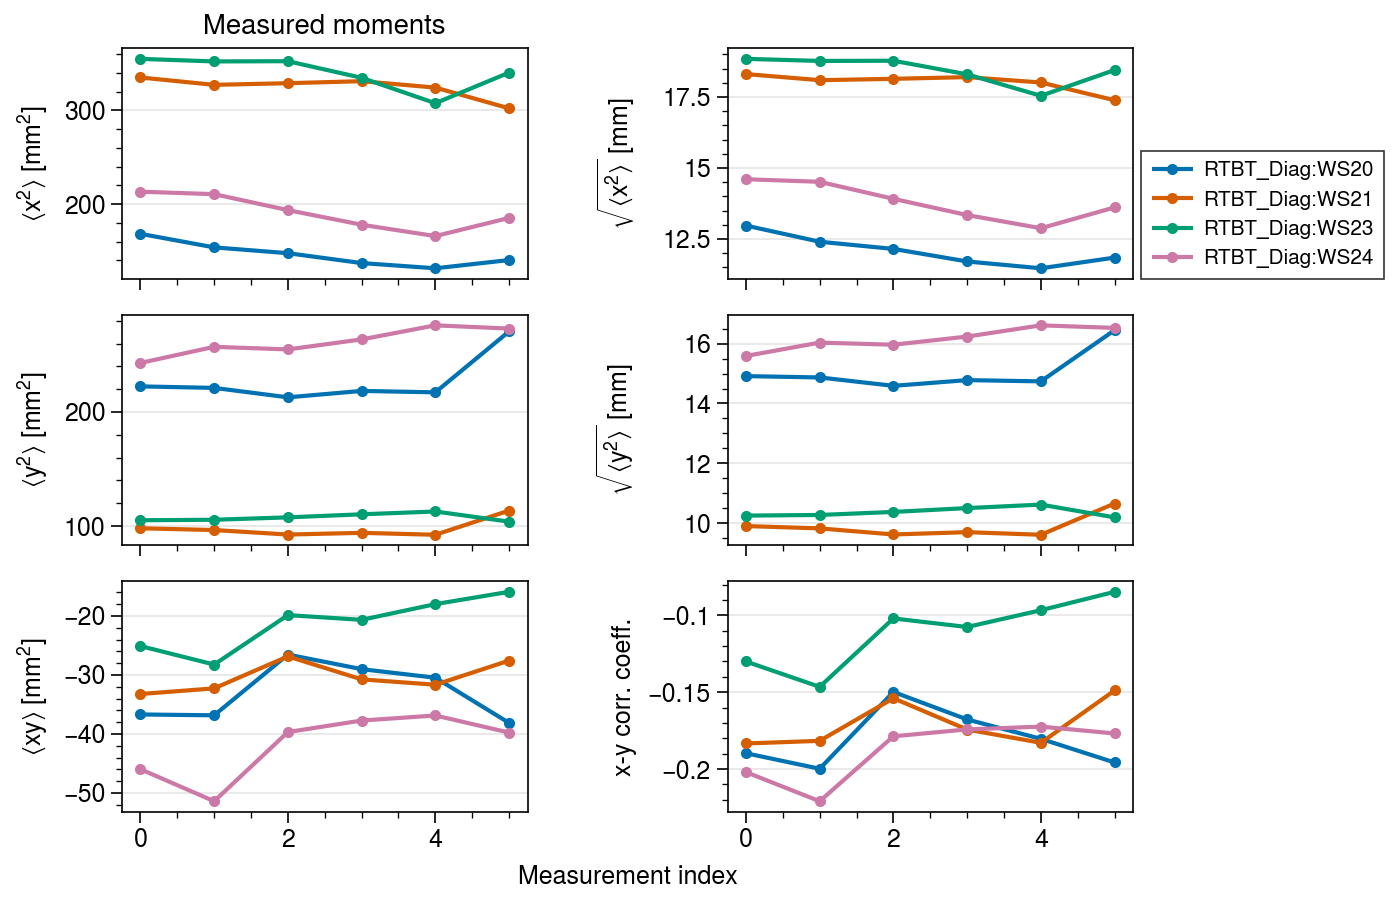

In [9]:
fig, axes = plot.subplots(ncols=2, nrows=3, figsize=(7, 4.5), spany=False, sharey=False, wspace=1, aligny=True)
plt_kws = dict(marker='.')
for ws_id in ws_ids:
    moments = moments_dict[ws_id]
    axes[0, 0].plot(moments[:, 0], **plt_kws)
    axes[1, 0].plot(moments[:, 1], **plt_kws)
    axes[2, 0].plot(moments[:, 2], **plt_kws)
    axes[0, 1].plot(np.sqrt(moments[:, 0]), **plt_kws)
    axes[1, 1].plot(np.sqrt(moments[:, 1]), **plt_kws)
    axes[2, 1].plot(moments[:, 2] / np.sqrt(moments[:, 0] * moments[:, 1]), **plt_kws)
axes[0, 0].format(ylabel=r'$\langle{x^2}\rangle$ [mm$^2$]')
axes[1, 0].format(ylabel=r'$\langle{y^2}\rangle$ [mm$^2$]')
axes[2, 0].format(ylabel=r'$\langle{xy}\rangle$ [mm$^2$]')
axes[0, 1].format(ylabel=r'$\sqrt{\langle{x^2}\rangle}$ [mm]')
axes[1, 1].format(ylabel=r'$\sqrt{\langle{y^2}\rangle}$ [mm]')
axes[2, 1].format(ylabel=r'x-y corr. coeff.')
for ax in axes:
    ax.grid(axis='y', alpha=0.1)
axes.format(xlabel='Measurement index')
axes[0, 1].legend(labels=ws_ids, ncols=1, loc=(1.02, 0), fontsize='small')
axes[0, 0].set_title('Measured moments');

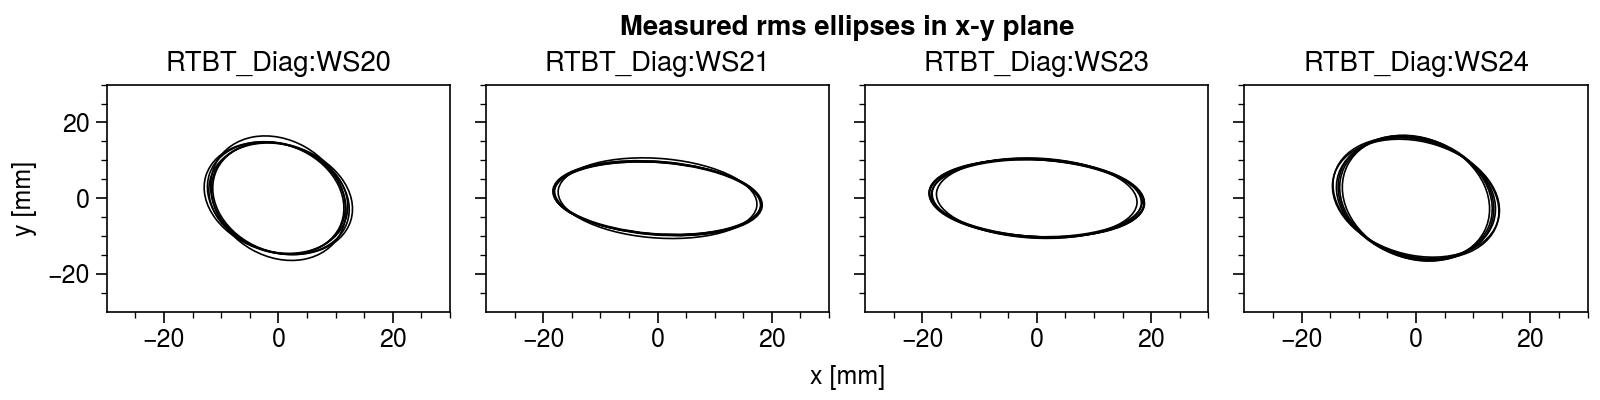

In [10]:
fig, axes = plot.subplots(ncols=4, figsize=(8, 2))
for ax, ws_id in zip(axes, ws_ids):
    ax.set_title(ws_id)
    for sig_xx, sig_yy, sig_xy in moments_dict[ws_id]:
        angle = -0.5 * np.arctan2(2*sig_xy, sig_xx-sig_yy)
        sn, cs = np.sin(angle), np.cos(angle)
        c1 = np.sqrt(abs(sig_xx*cs**2 + sig_yy*sn**2 - 2*sig_xy*sn*cs))
        c2 = np.sqrt(abs(sig_xx*sn**2 + sig_yy*cs**2 + 2*sig_xy*sn*cs))
        myplt.ellipse(ax, c1, c2, angle)
axes.format(xlim=(-30, 30), ylim=(-30, 30), xlabel='x [mm]', ylabel='y [mm]',
            suptitle='Measured rms ellipses in x-y plane')

## Analysis

In [11]:
tmats_list, moments_list = [], []
for ws_id in ws_ids:
    tmats_list.extend(tmats_dict[ws_id])
    moments_list.extend(moments_dict[ws_id])

In [12]:
Sigma = reconstruct(tmats_list, moments_list, verbose=2)

The unconstrained solution is optimal.
Final cost 4.4288e+03, first-order optimality 7.10e-10


In [13]:
Corr = utils.cov2corr(Sigma)
alpha_x, alpha_y, beta_x, beta_y, _, _ = ba.get_twiss2D(Sigma)
eps_x, eps_y = ba.apparent_emittances(Sigma)
eps_1, eps_2 = ba.intrinsic_emittances(Sigma)
coupling_coeff = 1.0 - np.sqrt((eps_1 * eps_2) / (eps_x * eps_y))

print('Sigma =')
print(Sigma)
print('Corr =')
print(Corr)
print('eps_4D = {:.3f}'.format(np.sqrt(np.linalg.det(Sigma))))
print('eps_1, eps_2 = {:.3f}, {:.3f}'.format(eps_1, eps_2))
print('eps_x, eps_y = {:.3f}, {:.3f}'.format(eps_x, eps_y))
print('alpha_x, alpha_y = {:.3f}, {:.3f}'.format(alpha_x, alpha_y))
print('beta_x, beta_y = {:.3f}, {:.3f}'.format(beta_x, beta_y))
print('Coupling coefficient = {}'.format(coupling_coeff))

Sigma =
[[132.22438094  29.02394835   9.06323335  -2.50129748]
 [ 29.02394835  10.29463098   5.93827178  -0.51453613]
 [  9.06323335   5.93827178 161.91844364 -10.49587901]
 [ -2.50129748  -0.51453613 -10.49587901   1.97252215]]
Corr =
[[ 1.          0.78667497  0.06194115 -0.15488117]
 [ 0.78667497  1.          0.14544759 -0.1141825 ]
 [ 0.06194115  0.14544759  1.         -0.58729961]
 [-0.15488117 -0.1141825  -0.58729961  1.        ]]
eps_4D = 318.493
eps_1, eps_2 = 23.889, 13.332
eps_x, eps_y = 22.777, 14.465
alpha_x, alpha_y = -1.274, 0.726
beta_x, beta_y = 5.805, 11.194
Coupling coefficient = 0.016794403394487345


In [14]:
norm = '2D'
V = np.identity(4)
if norm == '2D':
    alpha_x, alpha_y, beta_x, beta_y, _, _ = ba.get_twiss2D(Sigma)
    V = V_matrix_4x4_uncoupled(alpha_x, alpha_y, beta_x, beta_y)
elif norm == '4D':
    U = np.array([[0, 1, 0, 0], [-1, 0, 0, 0], [0, 0, 0, 1], [0, 0, -1, 0]])
    eigvals, eigvecs = np.linalg.eig(np.matmul(Sigma, U))
    V = BL.construct_V(eigvecs)
Vinv = np.linalg.inv(V)
Sigma_n = np.linalg.multi_dot([Vinv, Sigma, Vinv.T])

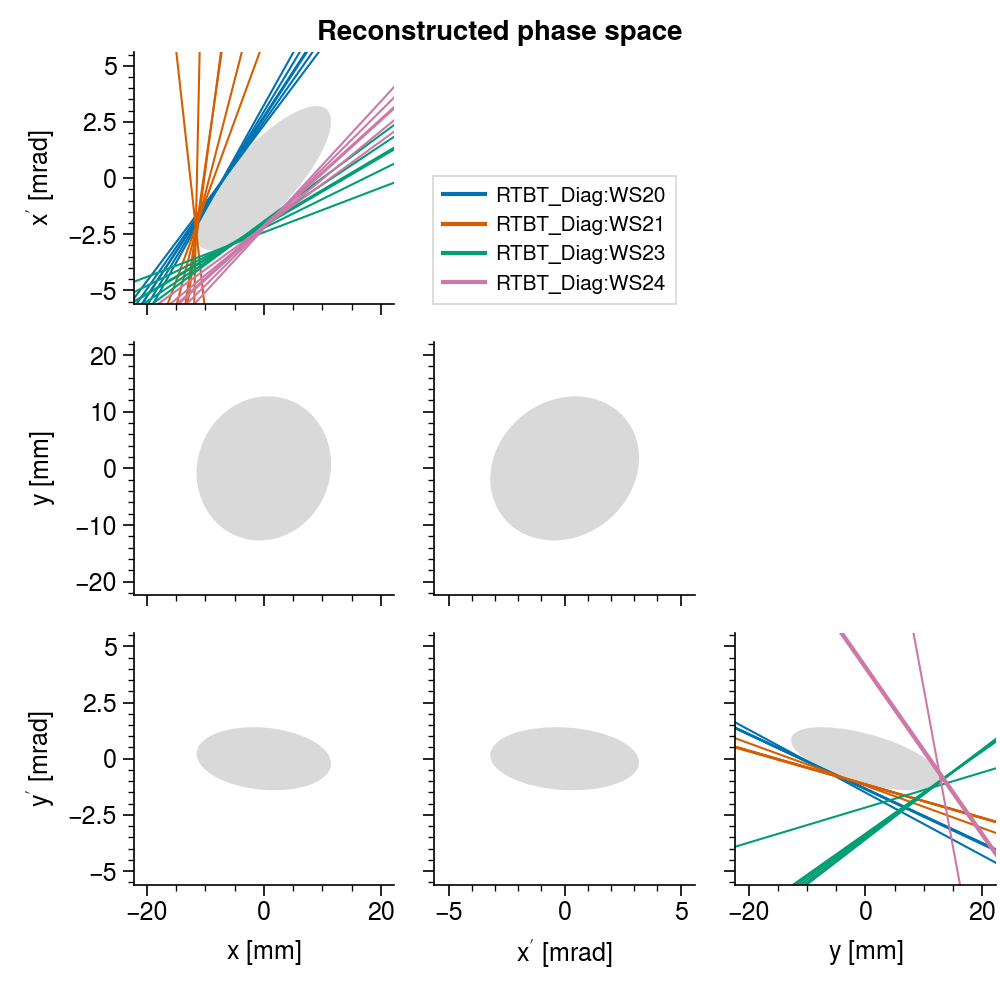

In [15]:
axes = myplt.rms_ellipses(Sigma, color='black', pad=0.75, alpha=0.15, fill=True, lw=0, zorder=0)
plt.suptitle('Reconstructed phase space')
reconstruction_lines(axes[2, 2], tmats_dict, moments_dict, plane='y-yp')
reconstruction_lines(axes[0, 0], tmats_dict, moments_dict, plane='x-xp',
                     legend=True, legend_kws=dict(loc=(1.15, 0)))

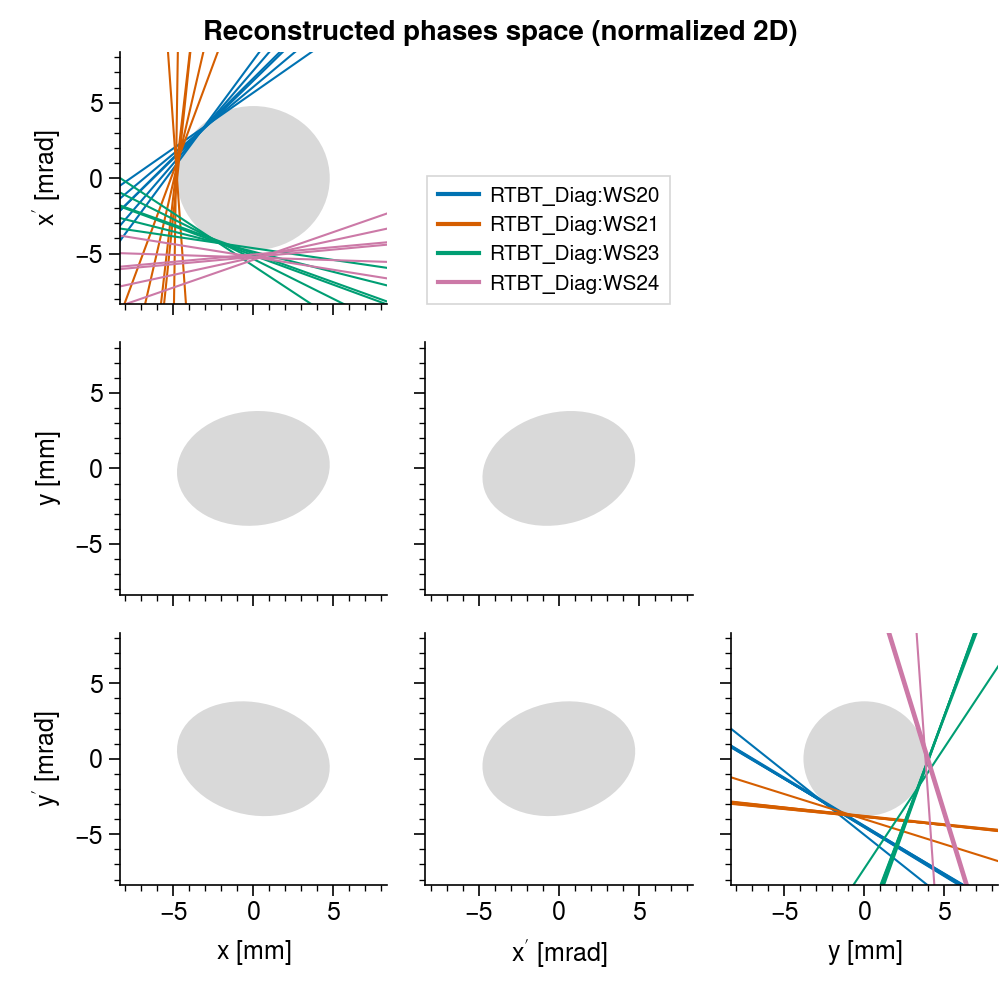

In [16]:
axes = myplt.rms_ellipses(Sigma_n, color='black', pad=0.75, alpha=0.15, fill=True, lw=0, zorder=0)
plt.suptitle('Reconstructed phases space (normalized {})'.format(norm))
reconstruction_lines(axes[2, 2], tmats_dict, moments_dict, plane='y-yp', norm_mat=V)
reconstruction_lines(axes[0, 0], tmats_dict, moments_dict, plane='x-xp', norm_mat=V,
                     legend=True, legend_kws=dict(loc=(1.15, 0)))